# Методы анализа узлов социального графа (Заднепровский А.)

In [1]:
import pandas as pd
import networkx as nx
import community
from matplotlib import pyplot as plt

## Загрузка данных

In [2]:
data = pd.read_csv("./vk_links.csv")

## Формирование графа

In [3]:
G = nx.MultiDiGraph([tuple(edge) for edge in data.values])

In [4]:
print("Вершин : %i \nРебер  : %i " % (G.number_of_nodes(), G.number_of_edges()))

Вершин : 491 
Ребер  : 16017 


## 1. Выделение сообществ
https://perso.crans.org/aynaud/communities/api.html#community.best_partition

In [5]:
partition = community.best_partition(G.to_undirected())

In [6]:
print("Число сообществ: %i" %  (max(partition.values())+1))

Число сообществ: 5


## 2 Разбиение сообществ на категории

In [7]:
def categorize(G, part, func):
    """
    Распределение узлов графа G по категориями в рамках сообществ part, используя функцию ранжирования func.
    """
    distrib = {"Лидеры": 0.05, "Посредники": 0.2}
    result = {node: 1 for node in G.nodes()}
    
    # Идем по всем сообществам
    for p in range(max(part.values())+1):
        print('{:^60}'.format("Сообщество " + str(p+1)))
        
        # Выделяем всех членов этого сообщества
        members = [key for key, val in part.items() if val == p]
        # Выделяем подграф соответсвующий этим членам
        sub_graph = nx.DiGraph(G).subgraph(members)
        # Вычисляем Page Rank
        pagerank = func(sub_graph)
        pagerank = sorted(pagerank.items(), key=lambda x: x[1])
        pagerank = [item[0] for item in pagerank]
        # Распределяем по категориям
        old = [0]
        for t, d in distrib.items():
            count = round(len(members)*d)
            selected_members = pagerank[old[-1]:count]
            old.append(count)
            print("{:11}: {}".format(t, selected_members))
            for member in selected_members:
                result[member] = len(old)
        print()  
    return result

### 2.1. Готовый алгоритм Page Rank
https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

In [8]:
category = [categorize(G, partition, nx.pagerank)]

                        Сообщество 1                        
Лидеры     : ['valeriap', 'leonidshow', 'id2658310', 'denisovaolesa', 'doronkinanatalia', 'lovego', 'alisaborkova', 'romeomosh', 'avrorin', 'anngelok']
Посредники : ['varvlad', 'anastasiavarlamova', 'id224209333', 'alexanderkadochnikov', 'cerber', 'chertovochkaa', 'annarich84', 'kackac', 'polinagaevskaya', 'nataliiaa', 'alexanderratnikov', 'id36442024', 'bki2013', 'linaliss', 'veraroo', 'demibrow', 'asya', 'id429966299', 'alievakat', 'id163234512', 'lindacherenkova', 'ofilatik', 'smaistrov', 'renokrenok', 'irinalerman', 'irasashkina', 'sushisuper', 'bochkov', 'makarenkos', 'glasir', 'id6964207']

                        Сообщество 2                        
Лидеры     : ['alekseevphoto', 'alexdpi', 'id300666', 'id5047', 'id249122548']
Посредники : ['freez', 'id20897800', 'engage', 'stunt78', 'id37795', 'lanly', 'vladimirtrudov', 'leragansta', 'antonovalyubov', 'angelinataburtsa', 'tanechka.tanyusha22', 'nineoneone', 'julyaosta

### 2.2 Разбиение сообществ на категории (свой алгоритм)
1. Присваеваем всем вершинам значение веса, равное числу входящих дуг;
2. Прибавляем к весу каждой вершины, сумму весов всех ссылающихся на нее вершин (умноженную на in_coef);
3. Прибавляем к весу каждой вершины, сумму весов всех вершин, на которые она ссылается (умноженную на out_coef).

In [9]:
def my_rank(G, in_coef=0.2, out_coef=0.01):
    result = dict(G.in_degree()) # 1
    result_copy = dict(result)
    # Проход по всем вершинам
    for node in G.nodes():
        # Проход по всем входящим дугам
        for in_edge in G.in_edges(node):
            result[node] += in_coef * result_copy[in_edge[0]] # 2
            
    result_copy = dict(result)
    # Проход по всем вершинам
    for node in G.nodes():
        # Проход по всем исходящим дугам
        for out_edge in G.out_edges(node):
            result[node] += out_coef * result_copy[out_edge[1]] # 3
    return result

In [10]:
category.append(categorize(G, partition, my_rank))

                        Сообщество 1                        
Лидеры     : ['leonidshow', 'cerber', 'kackac', 'bki2013', 'hesarocker', 'makashenets', 'anastasiavarlamova', 'anngelok', 'id167709277', 'smaistrov']
Посредники : ['irinalerman', 'geldman', 'darlingyulia', 'alievakat', 'demibrow', 'lindacherenkova', 'alexanderratnikov', 'romeomosh', 'alisaborkova', 'denisovaolesa', 'id36442024', 'boojywoo', 'doronkinanatalia', 'smallfly', 'id163234512', 'irasashkina', 'polinagaevskaya', 'valeriap', 'id58602529', 'chertovochkaa', 'veraroo', 'id2658310', 'nikitarubtsov', 'id224209333', 'lovego', 'nataliiaa', 'annarich84', 'virgykoval', 'philipprus', 'glasir', 'talalay']

                        Сообщество 2                        
Лидеры     : ['alexdpi', 'id5047', 'leragansta', 'dimabumagin', 'id1934']
Посредники : ['alekseevphoto', 'vladimirtrudov', 'sechko1', 'id23555', 'shtepaigor', 'lanly', 'sontales', 'leylaf', 'alionamarkovich', 'a.bratukhina', 'zlenko', 'id300666', 'tanechka.tanyusha22'

## 3. Визуализация результатов (для своего алгоритма)

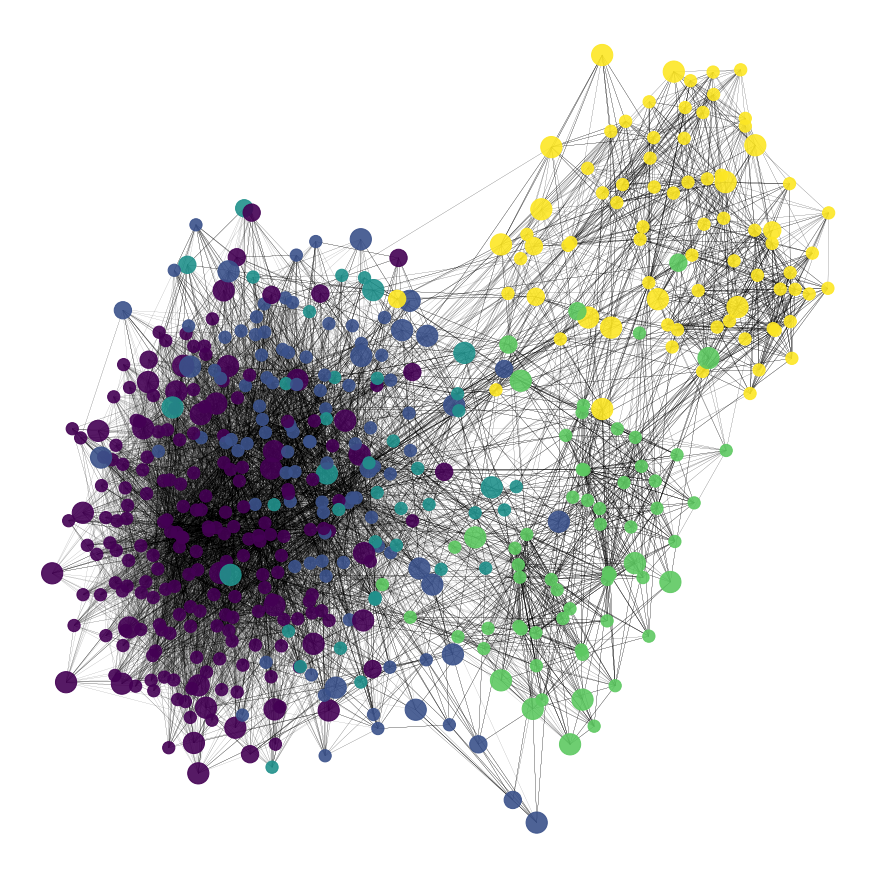

In [11]:
nx.draw(G.to_undirected(),
        width=0.1,
        ax = plt.axes((0, 0, 2, 3)),
        alpha=0.9,
        linewidth=100,
        node_size=[i * 150 for i in category[1].values()],
        node_color=list(partition.values()))

## Выходные данные

In [12]:
for i in range(2):
    out = pd.DataFrame()
    out["User"] = partition.keys()
    out["Community_ID"] = partition.values()
    out["User_type"] = ['leader' if c == 3 else 'agent' if c == 2 else 'follower' for c in category[i].values()]
    out.to_csv("out%i.csv" % (i+1))